In [1]:
import pandas as pd
import numpy as np

import lib.transformers as tf
from sklearn.pipeline import Pipeline

from lib.models import Ganomaly1d, Ganomaly2d, GanomalyFE, GanomalyNet
from lib.visualization import GANomalyBoard, rename_tensorboard_key

from skorch.callbacks import PassthroughScoring, ProgressBar
import torch

from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from keras.datasets import mnist
import tensorflow

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from lib.others import create_dataset

from lib.others import build_model
from lib.visualization import lineplot_comparison

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cwruData0 = pd.read_parquet('data/cwru0.parquet')
cwruData1 = pd.read_parquet('data/cwru1.parquet')

cwruData = pd.concat([cwruData0, cwruData1])

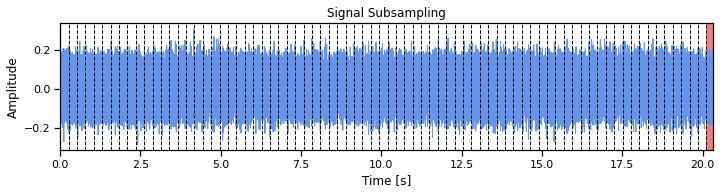

In [3]:
signal_length = 243938
subsample_length = 3136
signal = cwruData.loc[0, 'driveEndData'][:signal_length]

#sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})   

plt.rcParams['agg.path.chunksize'] = 10000
sns.set_context('notebook')
fig, ax = plt.subplots(figsize = (11.7, 11.7 / 5))

sampleRate = 12000

time = np.arange(0, 243938 / 12000, 1/sampleRate)[:-1]

g = sns.lineplot(x=time, y=signal, linewidth=1, ax = ax, color='cornflowerblue')

for i in range(1, (signal_length // subsample_length) + 1):
    ax.axvline(i * 3136 / 12000, color = 'black', linestyle='--', linewidth = 1)

ax.set(xlim=(0, 243938 / 12000))
ylims = ax.get_ylim()

ax.fill_between([signal_length // subsample_length * 3136 / 12000, signal_length], ylims[0], ylims[1],  facecolor='lightcoral', interpolate=True, alpha=1, zorder=2)
ax.set(ylim=ylims)

g.set_title('Signal Subsampling')
g.set_ylabel('Amplitude')
g.set_xlabel('Time [s]')
g.grid(False)
#sns.set_context("paper", rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})   

fig.savefig('data/data preparation/chunking.png', dpi=330, bbox_inches='tight')

In [4]:
normal_features, normal_labels = create_dataset(cwruData, feature_columns = ['fanEndData', 'driveEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Normal Baseline'], sampleRate = [12000])
ball_features, ball_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Ball Fault'], sampleRate = [12000])
inner_features, inner_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Inner Race Fault'], sampleRate = [12000])
outer_features, outer_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Outer Race Fault'], sampleRate = [12000])

In [5]:
inner_features, inner_labels = \
create_dataset(cwruData,
               feature_columns = ['fanEndData'],
               label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'],
               condition = ['Outer Race Fault'], 
               sampleRate = [12000]
              )

print('Labels (Time Series Samples)')
display(inner_labels.head(5))
print('Features (Time Series Samples)')
display(inner_features.head(5))

Labels (Time Series Samples)


,condition,faultDiameter,motorLoad,relativeFaultPosition,faultyBearingPosition,vibrationOrigin,index
0,Outer Race Fault,0.007,0,centered,drive end,fanEndData,36
1,Outer Race Fault,0.007,0,centered,drive end,fanEndData,36
2,Outer Race Fault,0.007,0,centered,drive end,fanEndData,36
3,Outer Race Fault,0.007,0,centered,drive end,fanEndData,36
4,Outer Race Fault,0.007,0,centered,drive end,fanEndData,36


Features (Time Series Samples)


0    [-0.40700545454545456, 0.26277636363636364, 0....
1    [-0.13046363636363634, 0.15881636363636362, -0...
2    [-0.3336581818181818, 0.2981145454545454, 0.00...
3    [0.08320909090909091, 0.012738181818181817, -0...
4    [0.12183454545454545, 0.3552309090909091, 0.05...
Name: vibrationData, dtype: object

In [6]:
import scipy
f, t, Zxx = scipy.signal.stft(normal_features[0], nperseg=112)

In [7]:
print('frequencies', f * 12000, 'times', t)

frequencies [   0.          107.14285714  214.28571429  321.42857143  428.57142857
  535.71428571  642.85714286  750.          857.14285714  964.28571429
 1071.42857143 1178.57142857 1285.71428571 1392.85714286 1500.
 1607.14285714 1714.28571429 1821.42857143 1928.57142857 2035.71428571
 2142.85714286 2250.         2357.14285714 2464.28571429 2571.42857143
 2678.57142857 2785.71428571 2892.85714286 3000.         3107.14285714
 3214.28571429 3321.42857143 3428.57142857 3535.71428571 3642.85714286
 3750.         3857.14285714 3964.28571429 4071.42857143 4178.57142857
 4285.71428571 4392.85714286 4500.         4607.14285714 4714.28571429
 4821.42857143 4928.57142857 5035.71428571 5142.85714286 5250.
 5357.14285714 5464.28571429 5571.42857143 5678.57142857 5785.71428571
 5892.85714286 6000.        ] times [   0.   56.  112.  168.  224.  280.  336.  392.  448.  504.  560.  616.
  672.  728.  784.  840.  896.  952. 1008. 1064. 1120. 1176. 1232. 1288.
 1344. 1400. 1456. 1512. 1568. 1624. 1680

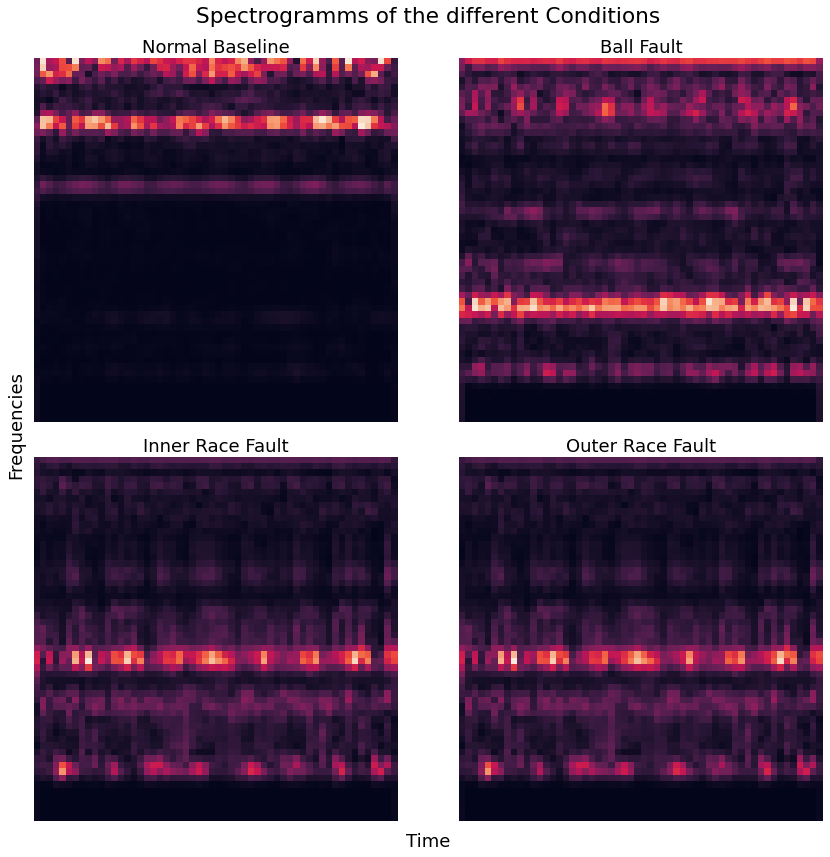

In [8]:
stft_transformer = tf.ArraySTFT()
data = stft_transformer.transform([normal_features[0], ball_features[0], inner_features[0], outer_features[0]])
import matplotlib.gridspec as gridspec
fig2 = plt.figure(constrained_layout=True, figsize = (11.7, 11.7))

sns.set_context('talk')

spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[1, 0])
f2_ax4 = fig2.add_subplot(spec2[1, 1])

p1 = sns.heatmap(data[0] ,square=True, cbar=False, ax = f2_ax1)
p2 = sns.heatmap(data[1] ,square=True, cbar=False, ax = f2_ax2)
p3 = sns.heatmap(data[2] ,square=True, cbar=False, ax = f2_ax3)
p4 = sns.heatmap(data[3] ,square=True, cbar=False, ax = f2_ax4)

p1.set(yticklabels=[], yticks=[], xticklabels=[], xticks=[], title = 'Normal Baseline')
p2.set(yticklabels=[], yticks=[], xticklabels=[], xticks=[], title = 'Ball Fault')
p3.set(yticklabels=[], yticks=[], xticklabels=[], xticks=[], title = 'Inner Race Fault')
p4.set(yticklabels=[], yticks=[], xticklabels=[], xticks=[], title = 'Outer Race Fault');
fig2.suptitle("Spectrogramms of the different Conditions");

f2_ax3.set_xlabel('.', color=(0, 0, 0, 0))
f2_ax3.set_ylabel('.', color=(0, 0, 0, 0))

fig2.text(0.5, 0, 'Time', ha='center')
fig2.text(0, 0.5, 'Frequencies', va='center', rotation='vertical')

fig2.savefig('data/data preparation/spectogramms.png', dpi=330, bbox_inches='tight')

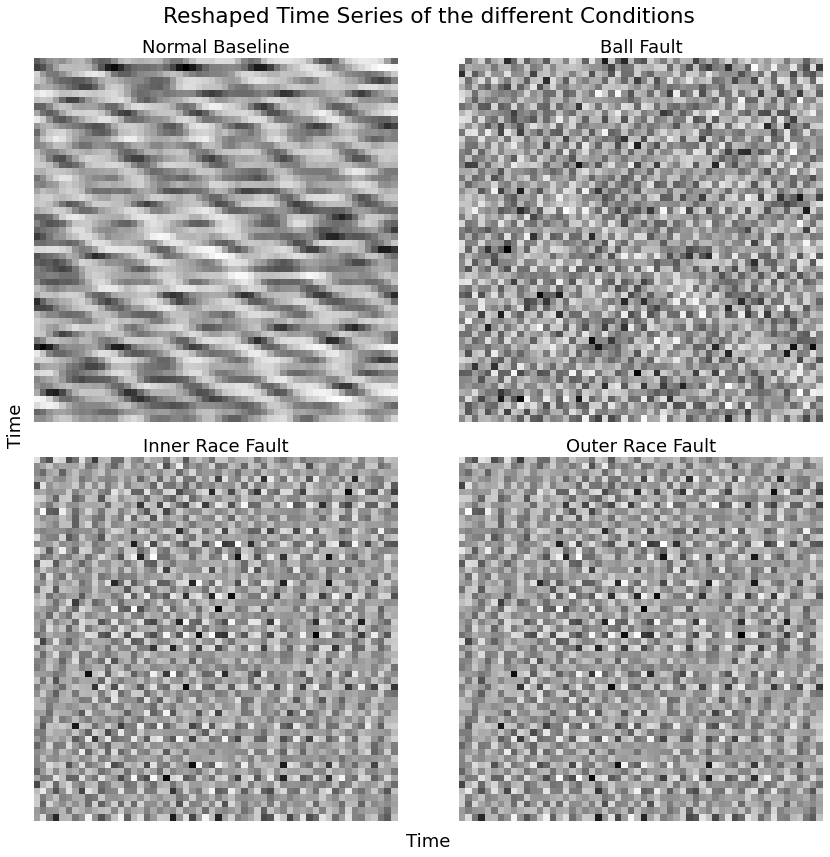

In [9]:
reshape_transformer = tf.ArrayReshaper((56, 56))
data = reshape_transformer.transform([normal_features[0], ball_features[0], inner_features[0], outer_features[0]])
import matplotlib.gridspec as gridspec
fig2 = plt.figure(constrained_layout=True, figsize = (11.7, 11.7))

sns.set_context('talk')

spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[1, 0])
f2_ax4 = fig2.add_subplot(spec2[1, 1])

p1 = sns.heatmap(data[0] ,square=True, cbar=False, ax = f2_ax1, cmap = 'Greys')
p2 = sns.heatmap(data[1] ,square=True, cbar=False, ax = f2_ax2, cmap = 'Greys')
p3 = sns.heatmap(data[2] ,square=True, cbar=False, ax = f2_ax3, cmap = 'Greys')
p4 = sns.heatmap(data[3] ,square=True, cbar=False, ax = f2_ax4, cmap = 'Greys')

p1.set(yticklabels=[], yticks=[], xticklabels=[], xticks=[], title = 'Normal Baseline')
p2.set(yticklabels=[], yticks=[], xticklabels=[], xticks=[], title = 'Ball Fault')
p3.set(yticklabels=[], yticks=[], xticklabels=[], xticks=[], title = 'Inner Race Fault')
p4.set(yticklabels=[], yticks=[], xticklabels=[], xticks=[], title = 'Outer Race Fault');
fig2.suptitle("Reshaped Time Series of the different Conditions");

f2_ax3.set_xlabel('.', color=(0, 0, 0, 0))
f2_ax3.set_ylabel('.', color=(0, 0, 0, 0))

fig2.text(0.5, 0, 'Time', ha='center')
fig2.text(0, 0.5, 'Time', va='center', rotation='vertical')

fig2.savefig('data/data preparation/stacked-time-series.png', dpi=330, bbox_inches='tight')

In [10]:
from scipy.fft import fftfreq
# Number of sample points
N = 3136
# sample spacing
T = 1/12000

fftfreq(N, T)[:N//2]

array([0.00000000e+00, 3.82653061e+00, 7.65306122e+00, ...,
       5.98852041e+03, 5.99234694e+03, 5.99617347e+03])

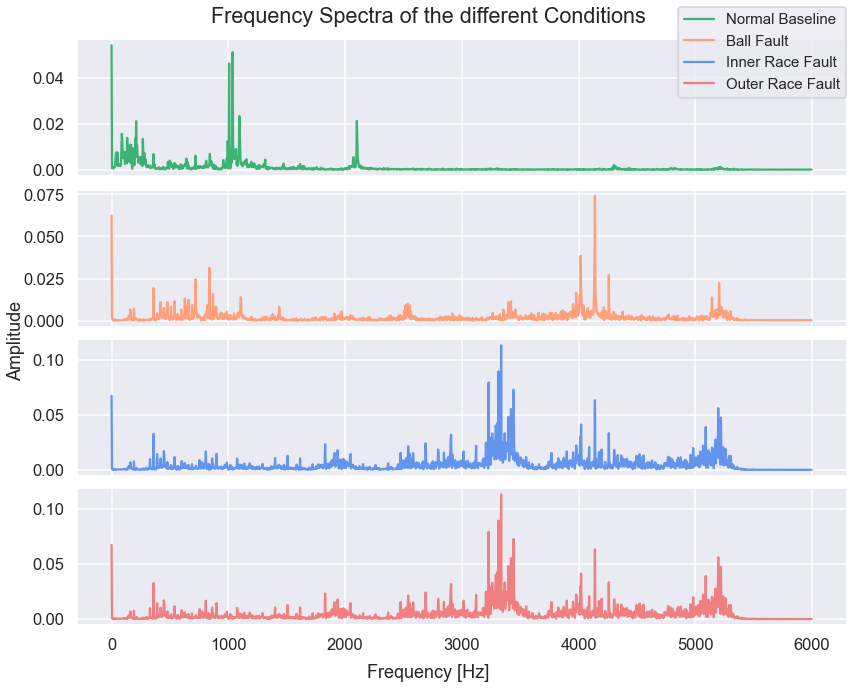

In [11]:
sns.set_context('talk')
fft_transformer = tf.ArrayFFT()
data = fft_transformer.transform([normal_features[0], ball_features[0], inner_features[0], outer_features[0]])

sns.set_style('darkgrid')

conditionFigure = plt.figure(constrained_layout=True, figsize = (11.7, 11.7 / 5 * 4))
cfSpec = gridspec.GridSpec(ncols=1, nrows=4, figure=conditionFigure)
conditionFigureAxis0 = conditionFigure.add_subplot(cfSpec[0, 0])
conditionFigureAxis1 = conditionFigure.add_subplot(cfSpec[1, 0])
conditionFigureAxis2 = conditionFigure.add_subplot(cfSpec[2, 0])
conditionFigureAxis3 = conditionFigure.add_subplot(cfSpec[3, 0])

#pyplot.xlabel('Time [s]')
#pyplot.ylabel('Amplitude')




p0 = sns.lineplot(x=fftfreq(N, T)[:N//2], y=data[0], color="mediumseagreen", ax = conditionFigureAxis0)
p0.set(xticklabels=[]) 



p1 = sns.lineplot(x=fftfreq(N, T)[:N//2], y=data[1], color="lightsalmon", ax = conditionFigureAxis1)
p1.set(xticklabels=[]) 

p2 = sns.lineplot(x=fftfreq(N, T)[:N//2], y=data[2], color="cornflowerblue", ax = conditionFigureAxis2)
p2.set(xticklabels=[]) 

sns.lineplot(x=fftfreq(N, T)[:N//2], y=data[3], color="lightcoral", ax = conditionFigureAxis3);

conditionFigureAxis3.set_xlabel('.', color=(0, 0, 0, 0))
conditionFigureAxis3.set_ylabel('.', color=(0, 0, 0, 0))

conditionFigure.text(0.5, 0, 'Frequency [Hz]', ha='center')
conditionFigure.text(0, 0.5, 'Amplitude', va='center', rotation='vertical')
conditionFigure.suptitle("Frequency Spectra of the different Conditions");
leg = conditionFigure.legend(loc='upper right', labels=['Normal Baseline', 'Ball Fault', 'Inner Race Fault', 'Outer Race Fault'], fontsize = 'small')

conditionFigure.savefig('data/data preparation/frequency-spectrum.png', dpi=330)

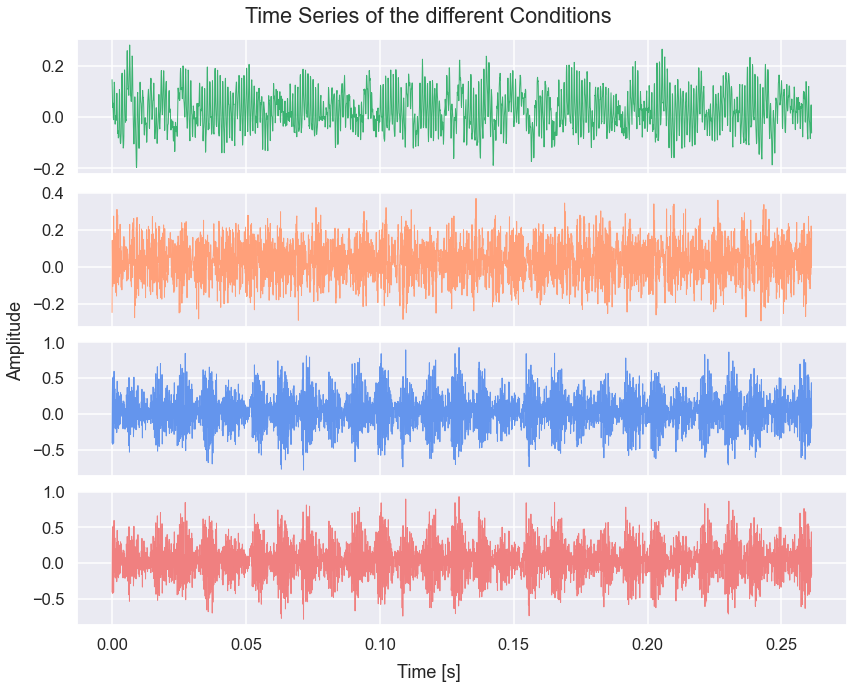

In [12]:
data = [normal_features[0], ball_features[0], inner_features[0], outer_features[0]]

conditionFigure = plt.figure(constrained_layout=True, figsize = (11.7, 11.7 / 5 * 4))
cfSpec = gridspec.GridSpec(ncols=1, nrows=4, figure=conditionFigure)
conditionFigureAxis0 = conditionFigure.add_subplot(cfSpec[0, 0])
conditionFigureAxis1 = conditionFigure.add_subplot(cfSpec[1, 0])
conditionFigureAxis2 = conditionFigure.add_subplot(cfSpec[2, 0])
conditionFigureAxis3 = conditionFigure.add_subplot(cfSpec[3, 0])

#pyplot.xlabel('Time [s]')
#pyplot.ylabel('Amplitude')

sampleRate = 12000

time = np.arange(0, 3136 / sampleRate, 1/sampleRate)

p0 = sns.lineplot(x=time, y=data[0], color="mediumseagreen", ax = conditionFigureAxis0, linewidth = 1)
p0.set(xticklabels=[]) 

p1 = sns.lineplot(x=time, y=data[1], color="lightsalmon", ax = conditionFigureAxis1, linewidth = 1)
p1.set(xticklabels=[]) 

p2 = sns.lineplot(x=time, y=data[2], color="cornflowerblue", ax = conditionFigureAxis2, linewidth = 1)
p2.set(xticklabels=[]) 

sns.lineplot(x=time, y=data[3], color="lightcoral", ax = conditionFigureAxis3, linewidth = 1);

conditionFigureAxis3.set_xlabel('.', color=(0, 0, 0, 0))
conditionFigureAxis3.set_ylabel('.', color=(0, 0, 0, 0))

conditionFigure.text(0.5, 0, 'Time [s]', ha='center')
conditionFigure.text(0, 0.5, 'Amplitude', va='center', rotation='vertical')
conditionFigure.suptitle("Time Series of the different Conditions");

conditionFigure.savefig('data/data preparation/time-series.png', dpi=330)

In [14]:
fe = tf.FeatureExtractor()
labels = pd.concat([ball_labels, inner_labels, outer_labels, normal_labels])
features = pd.concat([ball_features, inner_features, outer_features, normal_features])
results =fe.transform(np.array(features.tolist()))

names_list= ['maximum_value', 'mean_value', 'minimum_value', 'standard_value',
                       'peak_to_peak_value', 'mean_amplitude', 'root_mean_square_value', 'skewness_value',
                       'kurtosis_value', 'waveform_indicator', 'pulse_indicator', 'kurtosis_index',
                       'peak_index', 'square_root_amplitude', 'margin_indicator', 'skewness_indicator']
names = dict(enumerate(names_list))

results = pd.DataFrame(results).rename(names, axis=1)
mm = MinMaxScaler()
results[names_list] = mm.fit_transform(results[names_list])

result = labels.reset_index(drop=True).join(results)
result = result.melt(['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition', 'vibrationOrigin', 'index'], var_name='extracted_feature')

result = result.assign(split = result.extracted_feature.map(dict((value, key) for key, value in names.items())))

result.split = result.split.apply(lambda value: True if value <= 7 else False)


NameError: name 'shorten_labels' is not defined

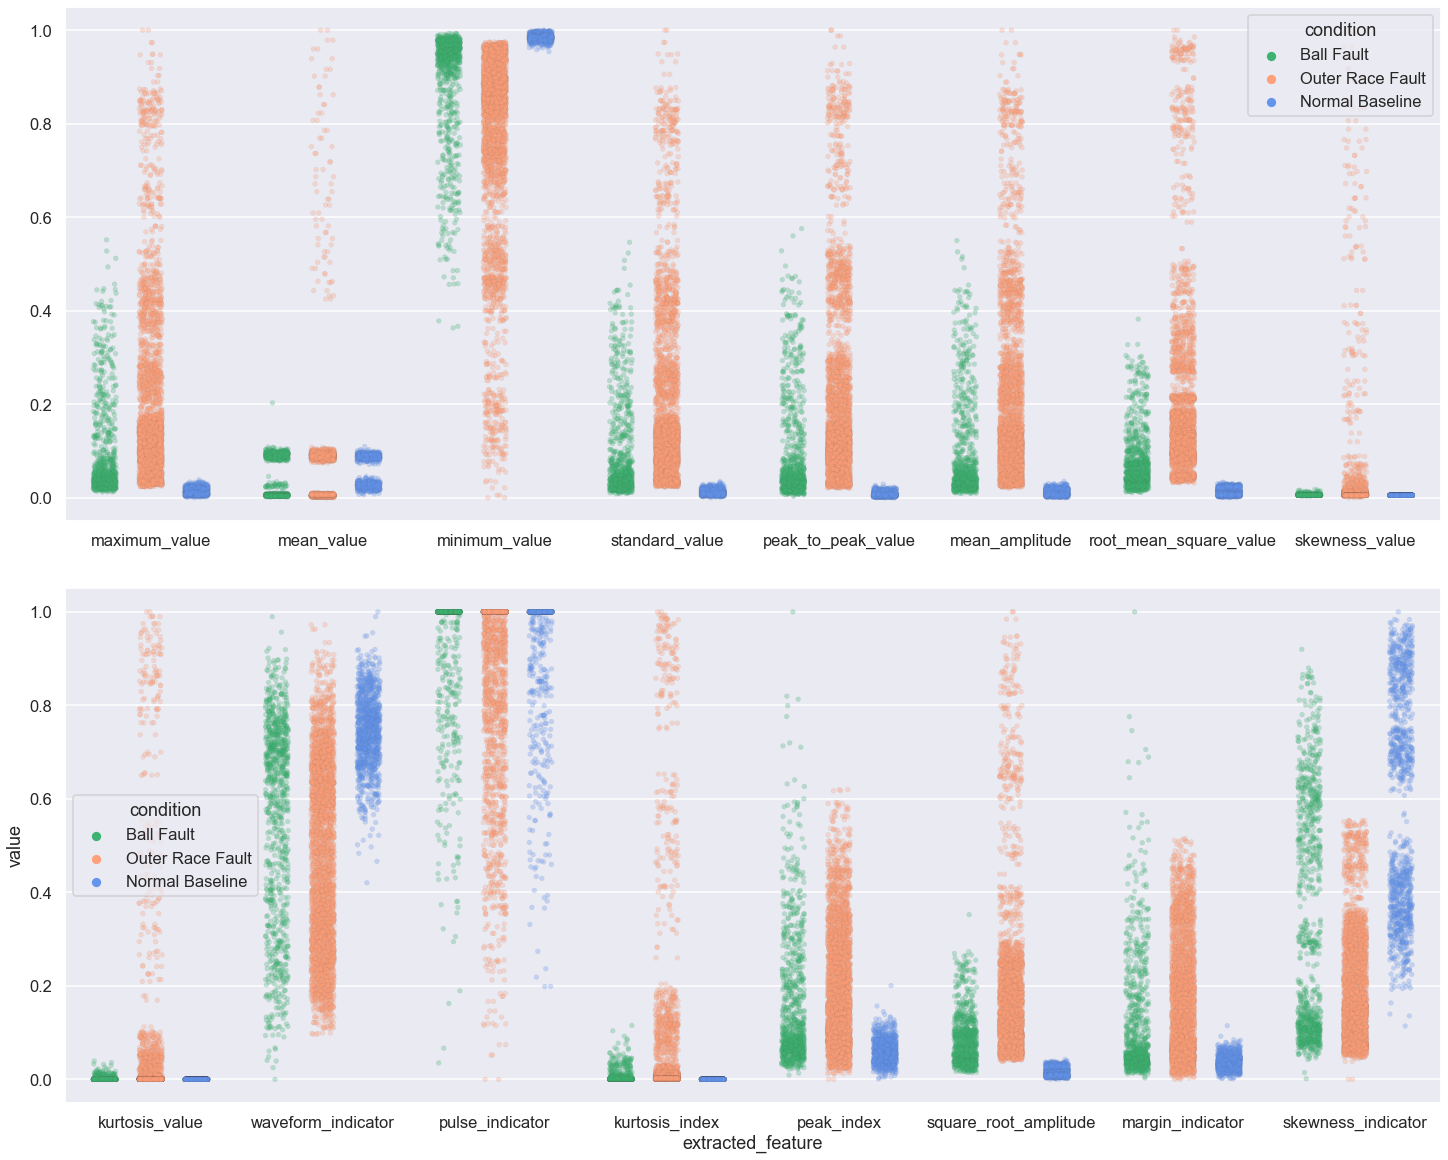

In [16]:
fefig = plt.figure(constrained_layout=True, figsize = (20, 20 / 5 * 4))

feSpec = gridspec.GridSpec(ncols=1, nrows=2, figure=fefig)
feAxis0 = fefig.add_subplot(feSpec[0, 0])
feAxis1 = fefig.add_subplot(feSpec[1, 0])

p0 = sns.stripplot(data = result[result.split == True], y = 'value', x = 'extracted_feature', hue='condition', dodge=True, alpha = 0.3, jitter = 0.2, linewidth = .1, size = 5, palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], ax = feAxis0)
p1 = sns.stripplot(data = result[result.split == False], y = 'value', x = 'extracted_feature', hue='condition', dodge=True, alpha = 0.3, jitter = 0.2, linewidth = .1, size = 5, palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], ax = feAxis1)

feAxis0.set_xlabel('.', color=(0, 0, 0, 0))
feAxis0.set_ylabel('.', color=(0, 0, 0, 0))
feAxis0.set_xticklabels(shorten_labels(feAxis0.get_xticklabels(), 15), ha='center');

feAxis1.set_xlabel('.', color=(0, 0, 0, 0))
feAxis1.set_ylabel('.', color=(0, 0, 0, 0))
feAxis1.set_xticklabels(shorten_labels(feAxis1.get_xticklabels(), 15), ha='center');

fefig.text(0.5, 0, 'Extracted Feature', ha='center')
fefig.text(0, 0.5, 'Scaled Value', va='center', rotation='vertical')

p1.legend_.remove()
handles, labels = feAxis0.get_legend_handles_labels()
feAxis0.legend(handles=handles, labels=labels)
#ax.set_xlabel('Extracted Feature')
#ax.set_ylabel('Scaled Value')
fefig.suptitle('Scaled Values of the Extracted Features')
fefig.savefig('data/data preparation/extracted-features.png', dpi=330, bbox_inches='tight')